In [10]:
import logging
import os
import warnings
import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)


In [11]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

from matplotlib.colors import ListedColormap

In [46]:
path_name = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RC_10_test_2/RC_10_'
colors = [teal2,yellow, beige1, green2, beige2, red1, teal4]
years = [2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035]

In [13]:
# Helper functions

from os import path


def get_power_prod(year,path_name=path_name):
    path = path_name + str(year) + '.nc'
    network = pypsa.Network(path)
    carrier_list = network.generators.carrier.unique()

    production_data = {}

    for carrier in carrier_list:
        total_production = network.generators_t.p.filter(like=carrier, axis=1).sum().sum() / 1000000  # Convert to TWh
        production_data[carrier] = total_production

    hydro_production = 0
    if 'hydro' in network.storage_units.carrier.unique():
        hydro_production += network.storage_units_t.p_dispatch.filter(like='hydro', axis=1).sum().sum() / 1000000  # Convert to TWh

    hydro_production += production_data.pop('ror', 0)
    production_data['hydro'] = hydro_production

    df = pd.DataFrame([production_data], index=[year])
    return df

def get_bus(bus_name, bus_info):
    if bus_name == bus_info['Bus']:
        return bus_info['x'], bus_info['y']

def get_demand(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1000000)
    return regional_demand.sum()

def total_production(year):
    prod = pd.DataFrame(get_power_prod(str(year)))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(year):
    total_prod = total_production(str(year))
    prod = get_power_prod(str(year))
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    df.index = [year]
    return df

def get_max_output(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    return network.generators.groupby(by='carrier')["p_max_pu"].sum()

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_objective(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    return network.objective

def get_total_cost(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    return (network.statistics.capex() + network.statistics.opex(aggregate_time="sum")).div(1e6)

def get_emissions(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

def get_installed_capacity(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)

    capacities = network.generators.groupby(by='carrier')['p_nom'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_snapshot_generation(year, first_date, second_date, carrier, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(year, first_date, second_date, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_cap_cost(year, path_name=path_name):
    path = path_name + year + '.nc'
    network = pypsa.Network(path)
    capital_cost = network.generators.groupby('carrier').capital_cost.mean().drop('load')
    return capital_cost

In [14]:
print(get_cap_cost(str(2021)).sum())

879045.8479249715


In [15]:
print(get_installed_capacity(str(2021)))
print(get_power_prod(str(2021)))

carrier     CCGT    OCGT  biomass    oil  onwind  solar  hydro
2021     1363.99  948.92    55.58  11.74   26.54  114.9  732.2
        onwind     solar      CCGT   biomass          OCGT           oil  \
2021  0.002466  0.211168  2.340489  0.486881  1.884718e-08  5.077851e-10   

          load     hydro  
2021  0.000001  6.414072  


carrier     CCGT    OCGT  biomass    oil  onwind  solar  hydro
2021     1363.99  948.92    55.58  11.74   26.54  114.9  732.2


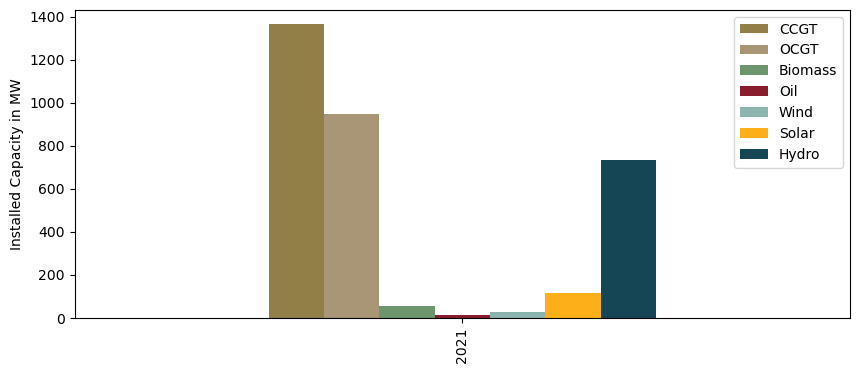

In [16]:
installed_capacity_21 = get_installed_capacity(str(2021))
installed_capacity_21.index = [2021]
print(installed_capacity_21)
colors_cap = [beige1, beige2, green2, red1, teal4, yellow, teal2]
names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro']
installed_capacity_21.columns = names
installed_capacity_21.plot(kind='bar',color=colors_cap,figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.show()

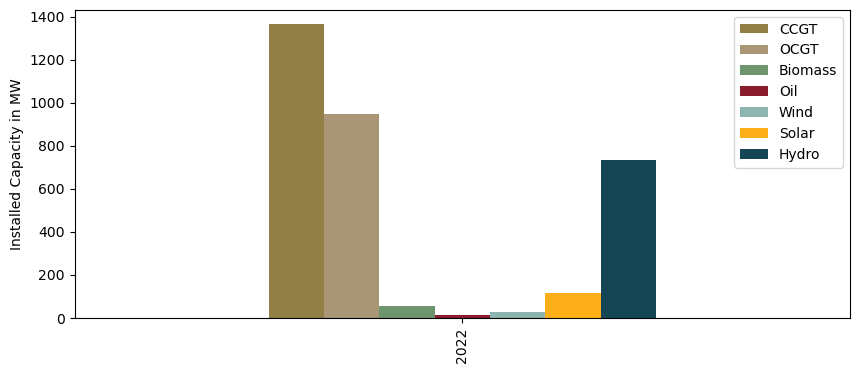

In [17]:
installed_capacity_22 = get_installed_capacity(str(2022))
installed_capacity_22.index = [2022]
colors_cap = [beige1, beige2, green2, red1, teal4, yellow, teal2]
names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro']
installed_capacity_22.columns = names
installed_capacity_22.plot(kind='bar',color=colors_cap,figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.show()

             CCGT        OCGT    biomass        oil     onwind        solar  \
2021  1363.990000  948.920000  55.580000  11.740000  26.540000   114.900000   
2022  1363.990000  948.920000  55.580000  11.740000  26.540000   114.900000   
2023  1363.990019  948.920885  55.580089  11.740003  26.541410   620.332294   
2024  1363.990043  948.922469  55.580094  11.740012  26.543618   689.393379   
2025  1363.990135  948.925250  55.580354  11.740026  26.545417   746.671364   
2026  1363.990157  948.930292  55.580365  11.740031  26.553555   804.299009   
2027  1363.990214  948.931648  55.580375  11.740082  26.554866   909.458100   
2028  1363.990237  948.932918  55.580408  11.740098  26.555133  1003.757423   
2029  1363.990289  948.935746  55.580466  11.740186  26.557103  1103.353081   
2030  1363.990306  948.941255  55.580516  11.740274  26.561035  1207.087727   
2031  1363.990470  948.942469  55.580795  11.740431  26.567015  1315.806596   
2032  1363.992996  948.942516  55.581208  11.740517 

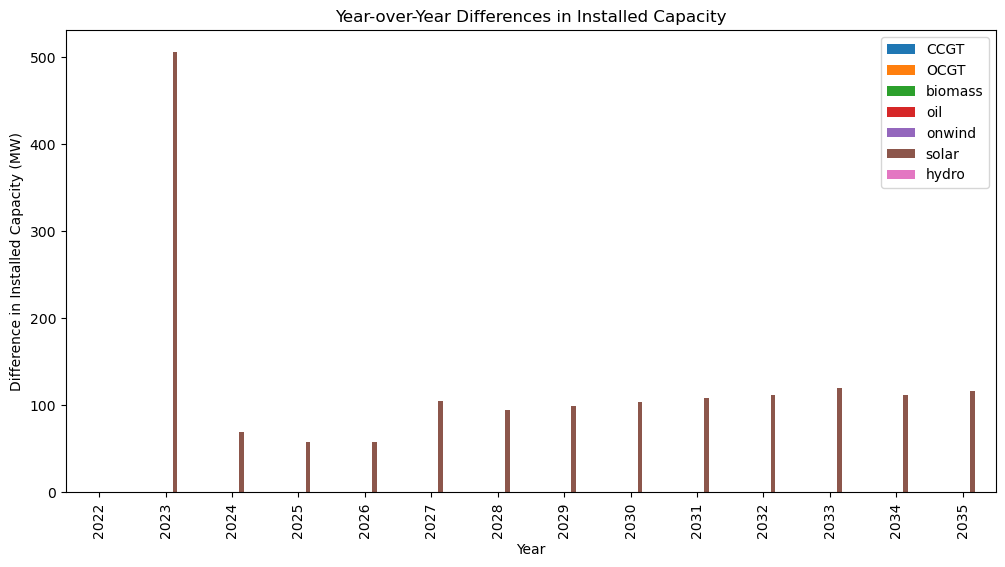

In [18]:
import pandas as pd
carriers = ['CCGT',    'OCGT',  'biomass',    'oil',  'onwind',  'solar',  'hydro']
installed_capacity_all_years = pd.DataFrame(columns=carriers)

# Loop through each year, retrieve the installed capacity, and append it to the DataFrame
for year in years:
    year_capacity_df = get_installed_capacity(str(year))
    installed_capacity_all_years = pd.concat([installed_capacity_all_years, year_capacity_df])

# installed_capacity_all_years now contains the installed capacity for each year
print(installed_capacity_all_years)

# If you want to calculate differences, use .diff() on the DataFrame
# Since the index is set as years, make sure to sort the DataFrame by the index before calculating the difference
installed_capacity_all_years = installed_capacity_all_years.sort_index()
year_over_year_diff = installed_capacity_all_years.diff().dropna()

# Plotting the differences
year_over_year_diff.plot(kind='bar', figsize=(12, 6))
plt.title('Year-over-Year Differences in Installed Capacity')
plt.ylabel('Difference in Installed Capacity (MW)')
plt.xlabel('Year')
plt.show()


In [47]:
data_agg=pd.DataFrame({})
for y in range(2021,2036):
    net=pypsa.Network(path_name + f"{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack()/1000  

grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
grouped_cap_change_B

carrier,CCGT,OCGT,biomass,hydro,onwind,ror,solar
year,,,,,,,
2021,2.344867e-09,6.414627e-07,2.991158e-11,0.0,6.318853e-07,0.0,0.505411
2022,7.045763e-08,2.547514e-07,0.000000e+00,0.0,8.043745e-08,0.0,0.072997
2023,4.886572e-10,1.123698e-08,3.743867e-09,0.0,6.400063e-08,0.0,0.071043
2024,2.668642e-07,1.567361e-08,3.536140e-08,0.0,1.399399e-07,0.0,0.060180
2025,5.922125e-09,2.513500e-07,6.211917e-09,0.0,9.912284e-08,0.0,0.060519
2026,1.890254e-08,7.812212e-07,1.054328e-06,0.0,7.955138e-08,0.0,0.080745
2027,4.383082e-11,3.185610e-07,2.109456e-08,0.0,2.586327e-07,0.0,0.061410
2028,3.028650e-07,5.637012e-07,2.091743e-06,0.0,3.185980e-07,0.0,0.064534
2029,1.008874e-06,6.682342e-08,2.498277e-08,0.0,2.356651e-07,0.0,0.064343


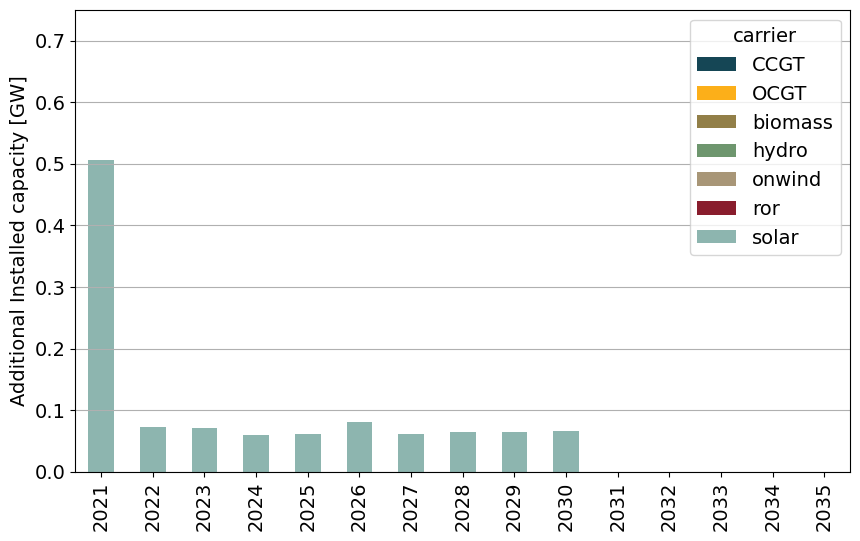

In [48]:
grouped_cap_change_B.plot.bar(stacked=True, figsize=(10, 6),color=colors)

# Add labels and title
plt.ylabel('Additional Installed capacity [GW]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_B.index)), grouped_cap_change_B.index, rotation=90)
plt.ylim(0.0,0.75)
plt.grid(axis = 'y',zorder = 0)

        onwind     solar      CCGT   biomass          OCGT           oil  \
2021  0.002466  0.211168  2.340489  0.486881  1.884718e-08  5.077851e-10   
2022  0.002139  1.127867  1.483886  0.429202  1.627637e-06  4.650249e-08   
2023  0.002138  1.251035  1.714795  0.428756  2.362798e-06  6.533208e-08   
2024  0.002118  1.353988  1.907802  0.428556  2.934481e-06  9.255562e-08   
2025  0.002115  1.456140  2.101303  0.428345  3.252924e-06  7.535657e-08   
2026  0.002118  1.644439  2.453701  0.427938  2.979197e-06  1.112684e-07   
2027  0.002151  1.816517  2.772309  0.428611  2.424521e-06  6.973108e-08   
2028  0.002131  1.995050  3.103627  0.428529  3.532513e-06  9.033722e-08   
2029  0.002136  2.178985  3.450446  0.428392  5.890583e-06  1.477453e-07   
2030  0.002161  2.370028  3.811903  0.428187  6.837181e-06  2.065009e-07   
2031  0.002153  2.568719  4.190755  0.430901  6.181018e-04  1.486997e-07   
2032  0.002174  2.777718  4.577748  0.432257  6.769317e-03  1.503901e-07   
2033  0.0021

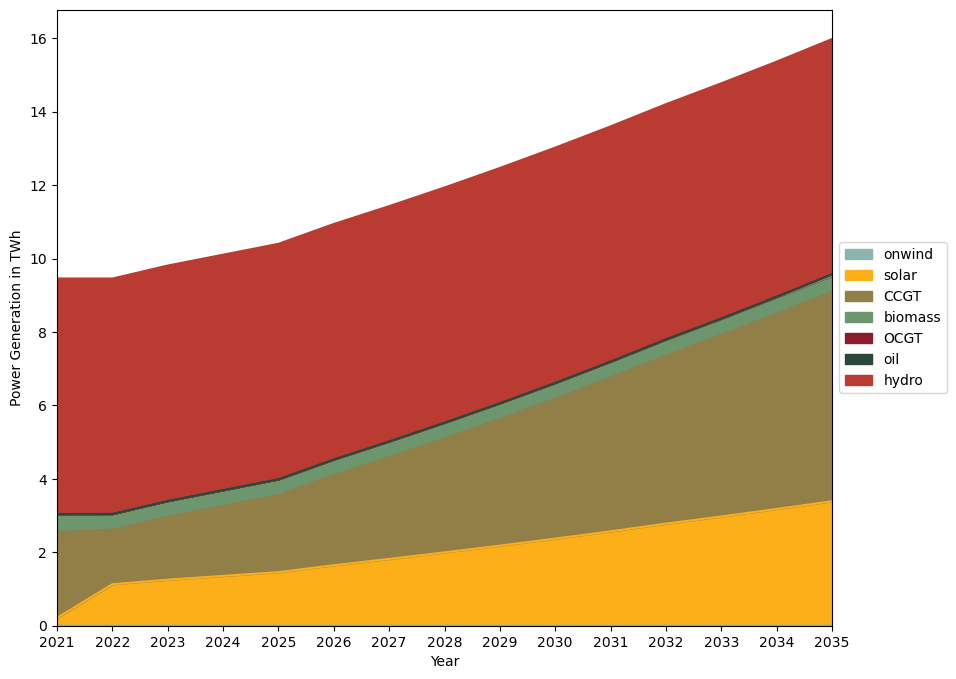

In [21]:
production_sources = [get_power_prod(str(year)) for year in years]
production = pd.concat(production_sources)
if 'load' in production:
  production.drop('load', axis=1, inplace=True)
print(production)
#names = ['Wind', 'Solar', 'CCGT', 'Biomass', 'OCGT', 'Oil', 'Hydro']
#production.columns = names

#colors = [color_for_wind, color_for_solar, color_for_ccgt, color_for_biomass, color_for_ocgt, color_for_oil, color_for_hydro]
colors = [teal4,yellow, beige1, green2, red1, green1, red2, teal2]

production.plot.area(stacked=True, color=colors,figsize=(10, 8))

plt.ylabel('Power Generation in TWh')
plt.xlabel('Year')
plt.xlim(0,14)
plt.xticks(range(len(years)), years)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

        onwind     solar      CCGT   biomass          OCGT           oil  \
2021  0.000261  0.022334  0.247538  0.051494  1.993340e-09  5.370503e-11   

         hydro  
2021  0.678373  


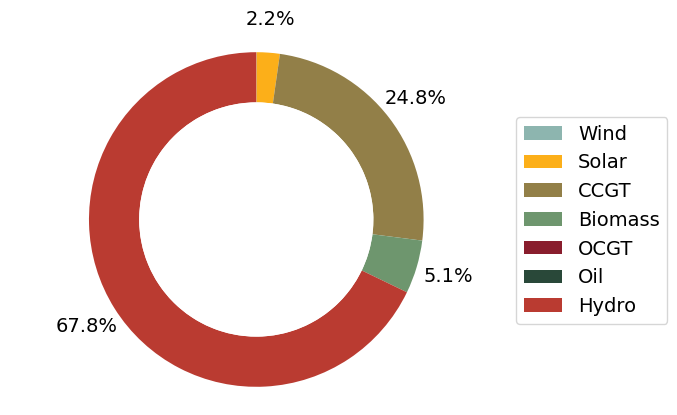

In [22]:
power_mix_df = get_power_mix(2021)
print(power_mix_df)
plt.rcParams['font.size'] = 14

names = ['Wind', 'Solar', 'CCGT', 'Biomass', 'OCGT', 'Oil', 'Hydro']
power_mix_df.columns = names

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=colors, startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.2)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() == '0.0%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)


plt.legend(names, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

        onwind     solar      CCGT   biomass      OCGT       oil     hydro
2035  0.000137  0.212041  0.356885  0.027318  0.002684  0.000004  0.400933


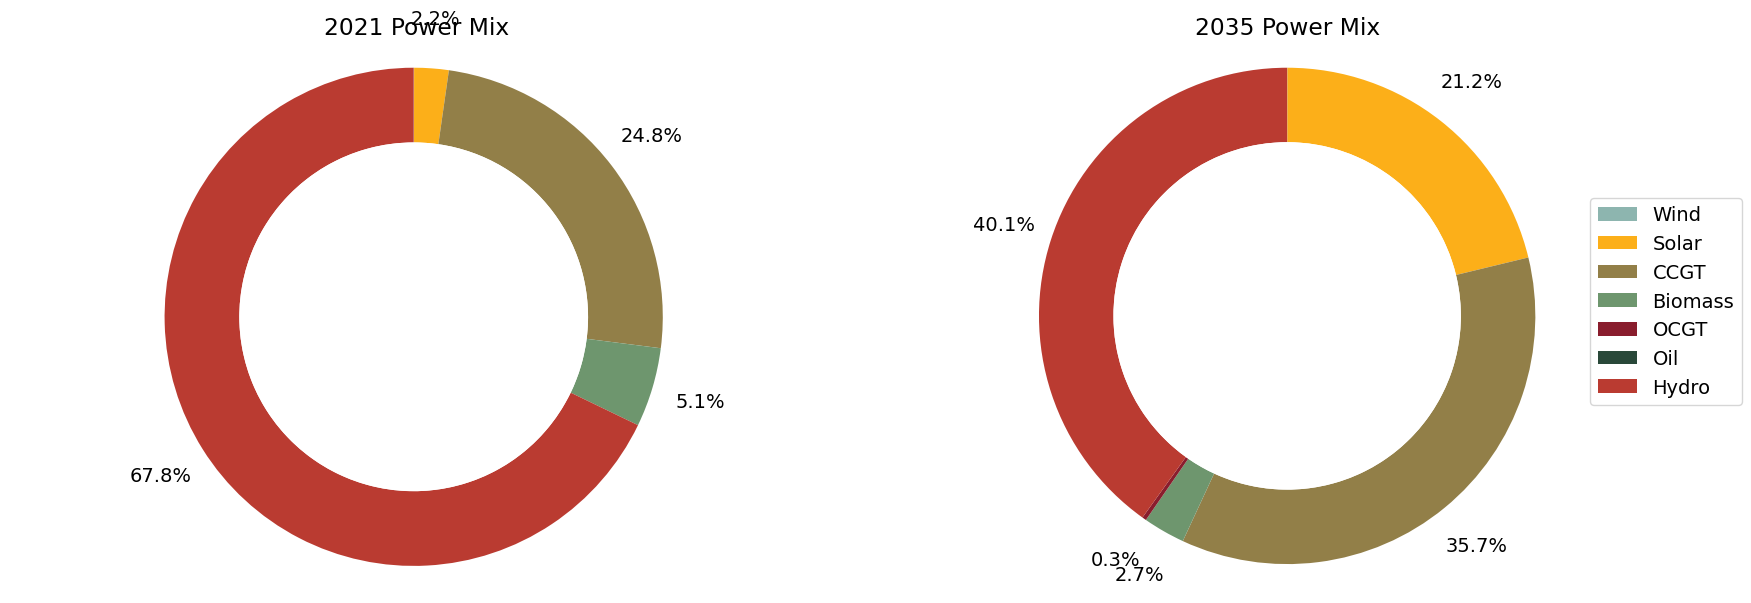

In [23]:
power_mix_21 = get_power_mix(2021)
power_mix_35 = get_power_mix(2035)
print(power_mix_35)

plt.rcParams['font.size'] = 14

names = ['Wind', 'Solar', 'CCGT', 'Biomass', 'OCGT', 'Oil', 'Hydro']
power_mix_21.columns = names
power_mix_35.columns = names

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

wedges1, texts1, autotexts1 = ax1.pie(
    power_mix_21.iloc[0].values, autopct=custom_autopct,
    colors=colors, startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.2
)

wedges2, texts2, autotexts2 = ax2.pie(
    power_mix_35.iloc[0].values, autopct=custom_autopct,
    colors=colors, startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.2
)

for autotext in autotexts1 + autotexts2:
    if autotext.get_text() == '0.0%':
        autotext.set_visible(False)

centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title('2021 Power Mix')

centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title('2035 Power Mix')

ax1.axis('equal')
ax2.axis('equal')

fig.legend(names, loc="center right", bbox_to_anchor=(1, 0.5))

plt.tight_layout(pad=3.0)
plt.show()

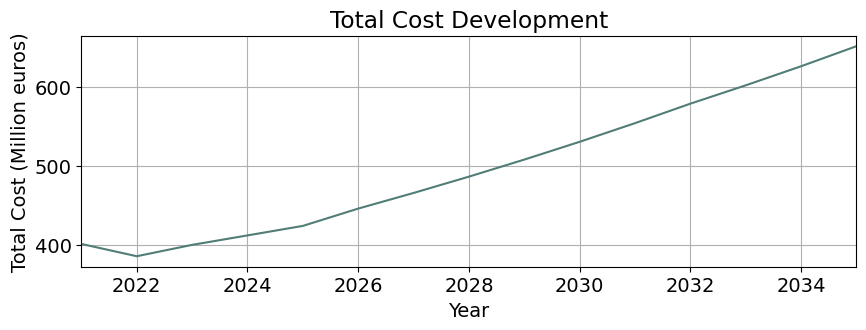

In [24]:
total_costs = [get_total_cost(str(year)).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_costs, color=teal3)
plt.title('Total Cost Development')
plt.xlabel('Year')
plt.ylabel('Total Cost (Million euros)')
plt.xlim(2021,2035)
plt.grid(zorder = 0)
plt.show()

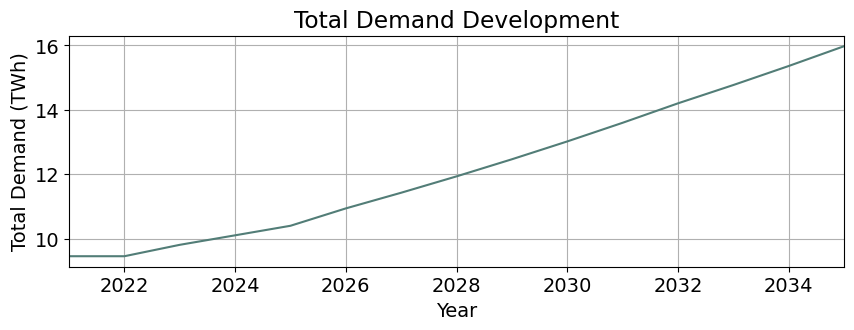

In [25]:
total_demand = [get_demand(str(year)) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_demand, color=teal3)
plt.title('Total Demand Development')
plt.xlabel('Year')
plt.ylabel('Total Demand (TWh)')
plt.xlim(2021,2035)
plt.grid(zorder = 0)
plt.show()

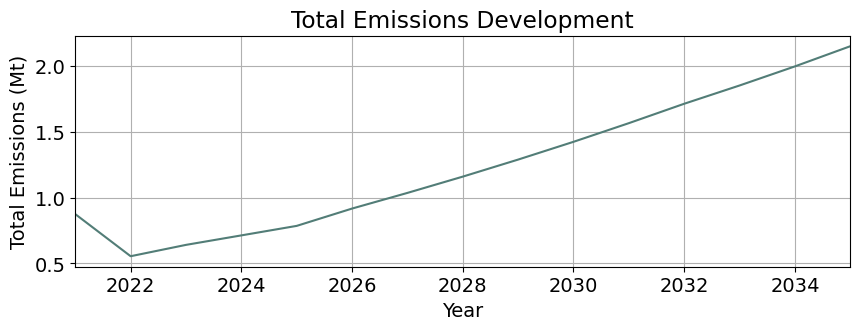

In [26]:
total_emissions = [get_emissions(str(year)) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_emissions, color=teal3)
plt.title('Total Emissions Development')
plt.xlabel('Year')
plt.ylabel('Total Emissions (Mt)')
plt.xlim(2021,2035)
plt.grid(zorder = 0)
plt.show()

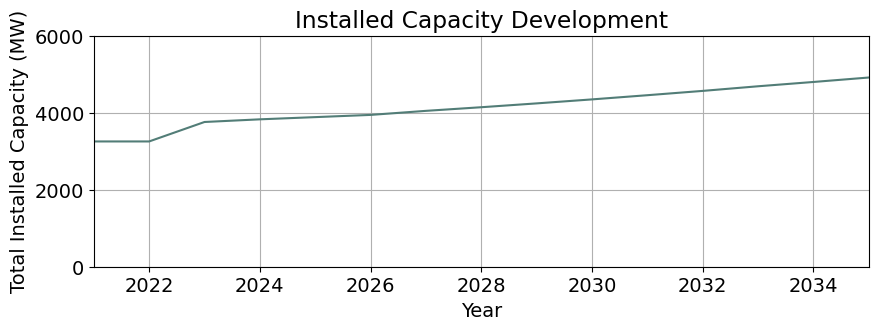

In [27]:
total_capacity = [get_installed_capacity(str(year)).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_capacity, color=teal3)
plt.title('Installed Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(2021,2035)
plt.ylim(0,6000)
plt.grid(zorder = 0)
plt.show()

Oil:  9.738530022698752e-06
Biomass:  9337.439949846732


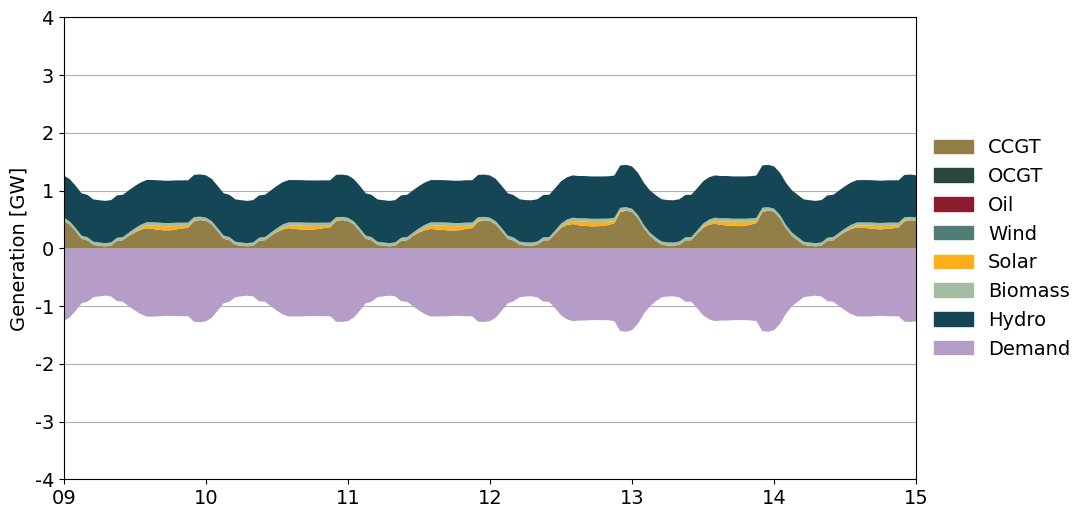

In [28]:
first_date = "2013-01-09"
second_date = "2013-01-15"
year = '2021'

CCGT = get_snapshot_generation(year, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(year, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(year, first_date, second_date, 'oil')
Wind = get_snapshot_generation(year, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(year, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(year, first_date, second_date, 'biomass')
Hydro = get_snapshot_generation(year, first_date, second_date, 'ror')
Hydro += get_snapshot_generation(year, first_date, second_date, 'hydro')
demand = get_snapshot_demand(year, first_date, second_date)   

print('Oil: ', Oil.sum())
print('Biomass: ', Biomass.sum())

fig, ax=plt.subplots(figsize = (11,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Wind, Solar, Biomass, Hydro, #,pbattery
                  colors=[beige1,green1,red1,teal3,yellow,green3,teal2], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand, colors=[purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-4000, 4000)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=green1, label ='OCGT')
oil_patch = mpatches.Patch(color = red1, label = 'Oil')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
load_patch = mpatches.Patch(color=purple3, label ='Demand')
handles=[CCGT_patch,OCGT_patch,oil_patch, wind_patch, solar_patch, biomass_patch, hydro_patch, load_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)

In [29]:
carrier_list_stat = ['Biomass', 'Combined-Cycle Gas', 'Oil', 'Onshore Wind', 'Open-Cycle Gas', 'Solar']
carrier_list = ['biomass', 'CCGT', 'ror', 'onwind', 'OCGT', 'solar']

n = pypsa.Network(path_name + "2024.nc")
capital_cost = n.generators.groupby('carrier').capital_cost.mean().drop('load')

data_agg=pd.DataFrame({})
for y in range(2021,2025):
    net=pypsa.Network(path_name + f"{y}.nc")

    capacity=pd.DataFrame(net.generators.head(19))
    hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
    caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
    caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
    caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
    
    data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
    
grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack()  

grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
grouped_cap_change_B


i =0.04
data_add_cost = {}

# Iterate over the carriers
for carrier in carrier_list:
    # Create a list to store the values for the current carrier
    carrier_values = []
    # Iterate over the years
    for y in np.arange(2021, 2025):
        # Calculate the value and append it to the carrier_values list
        value = 0
        for rest in np.arange(2025-y):
            if rest > 0:
                value += (grouped_cap_change_B[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
            
        carrier_values.append(value)
    # Add the carrier_values list to the data dictionary with the carrier as the key
    data_add_cost[carrier] = carrier_values

# Create the DataFrame from the data dictionary
add_cost_B = pd.DataFrame(data_add_cost, index=np.arange(2021, 2025))
add_cost_B

,biomass,CCGT,ror,onwind,OCGT,solar
2021,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00
2022,43.920722,0.550027,0.0,81.956329,5.512446,4.847986e+07
2023,0.161200,1.350814,0.0,22.258474,9.652522,3.376897e+06
2024,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00


In [30]:
objective_value_list_B = []
for y in range(2021,2025):
    net=pypsa.Network(path_name + f"{y}.nc")
    objective_value_list_B.append(net.objective)

In [31]:
print(objective_value_list_B)
print(add_cost_B.sum(axis=1))

[93037277.7611582, 77462101.16704503, 66162629.97681773, 74672801.74433434]
2021    0.000000e+00
2022    4.848000e+07
2023    3.376931e+06
2024    0.000000e+00
dtype: float64


In [32]:
data={"year":[],"total_costs":[]}
for y in np.arange(2021,2025):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_B[y-2021]/((1+i)**(y-2021))+ add_cost_B.sum(axis = 1)[y]/((1+i)**(y-2021))) #objective_value_B[y]+

total_costs_B=pd.DataFrame(data)
total_costs_B

,year,total_costs
0,2021,9.303728e+07
1,2022,1.210982e+08
2,2023,6.429323e+07
3,2024,6.638385e+07


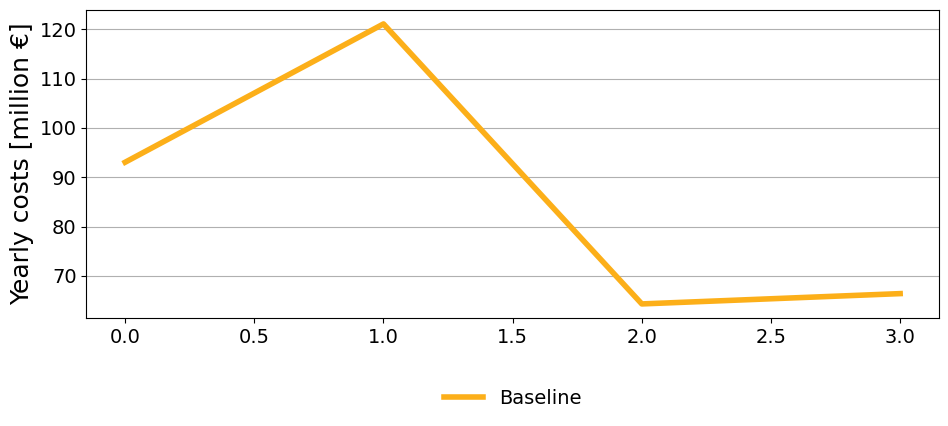

In [33]:
(total_costs_B['total_costs']/1000000).plot(figsize=(11, 4),color = yellow, linewidth = 4, zorder = 2, label = 'Baseline')
plt.ylabel('Yearly costs [million €]',fontsize = 18)
plt.grid(axis='y')
#plt.xlim(2021,2035)
plt.legend(frameon = False, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4)
